## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
from arabic_pronounce import phonetise

/home/shams022u1/.conda/envs/py37/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shams022u1/.conda/envs/py37/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shams022u1/.conda/envs/py37/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shams022u1/.conda/envs/py37/lib/python3.6/s

In [3]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [4]:
hparams = create_hparams()
hparams.sampling_rate = 22050
hparams.max_decoder_steps = 2000
hparams.gate_threshold=0.3


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [5]:
checkpoint_path = "outdir/checkpoint_55000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [6]:
waveglow_path = 'waveglow_256channels_ljs_v2.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/home/shams022u1/.conda/envs/py37/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/shams022u1/.conda/envs/py37/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/shams022u1/.conda/envs/py37/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve t

In [7]:
def _maybe_get_arpabet(word):
        pronunciations = phonetise(word)
        toBeReturned = '{%s}' % pronunciations[0] if len(pronunciations)==1 else '{%s}' % pronunciations[1]
        return toBeReturned

#### Prepare text input

In [12]:
# text = "عَلَى حَدِّ قَوْلِ الْبَاحِثَةِ"
# text = "وَكَامِرَاتِ التَّصْوِيرِ الْمُدْمَجَةِ ذَاتِ الدِّقَّةِ الْعَالِيَةِ"
# text = "لِيَتَمَكَّنَ الْقَارِئُ مِنْ مُتَابَعَةِ تَطَوُّرِ الْقِصَّةِ الْخَبَرِيَّةِ بِشَكْلٍ سَلِسٍ وَفَعَّالٍ"
# text = "وَبِهَذِهِ النَّتِيجَةِ تَتَصَدَّرُ السِّنِغَالُ مَجْمُوعَتَهَا بِرَصِيدِ ثَلاثِ نِقَاطٍ وَهَدَفَيْنِ نَظِيفَيْنْ"
# text = "وَحَالَةِ الْإِسْتِقْطَابِ السِّيَاسِيِّ الْحَادِّ"
# text = "بَيْنَهَا فِيلْمٌ تُونُسِيٌّ وَاحِدٌ"
text = "أَلْحَاصِلُ عَلَى السَّعْفَةِ الذَّهَبِيَّةِ بِمِهْرَجَانِ كَان السِّينَمَائِيِّ الْأَخِيرِ"
# text = "وَغَيْرِهَا مِنْ رَوَافِدِ الثَّقَافَةِ أَلْعَرَبِيَّةِ وَالْإِسْلَامِيَّةِ"
# text = "عَلَى الْمُثَلَّثِ الْحُدُودِيِّ - أَلَّذِي يَجْمَعُ بَيْنَ أَلْمَانِيَا - وَسُوِسْرَا - وَالنِّمْسَا مُبَاشَرَةً"
# text = "بَيْنَهَا نَهْرَا يَلُو وَيَانْغْتسِي - فِي الصِّينْ"
# text   = "وَالْمُحَافَظَةُ عَلَى الْقَدْرِ الْكَافِي مِنَ النَّوْمِ"
# text = "وَيُشَكِّلُ الْإِيغُور - أَغْلَبِيَّةَ سُكَّانِ إِقْلِيمِ شَنْغْيانْغْ"
# text = "مِمَّا قَدْ يُؤَدِّي إِلَى تَرَاجُعِ مَسَاحَاتِ الْأَنْهَارِ الجَّلِيدِيَّةِ وَانْتِشَارِ التَّصَحُّرِ"
# text = "تُخَطِّطُ شَرِكَةٌ أَمِرِكِيَّةٌ - غَيْرُ رِبْحِيَّةٍ - تُدْعَى صُنْدُوقُ الْإِسْتِثْمَارِ لِتَنْمِيَةِ الْإِعْلَامِ - لِتَزْوِيدِ كُلِّ سُكَّانِ الْأَرْضِ بِالْإِنْتِرْنِت - أَللَّاسِلْكِيِّ - أَلْمَجَّانِيِّ - بِاسْتِخْدَامِ مِئَاتِ الْأَقْمَارِ الصِّنَاعِيَّةِ الْمُصَغَّرَةِ"
# text = "يَتَمَثَّلُ الْإِبْدَاعُ الْفَنِّيُّ وَالْحَضَارِيُّ الَّذِي يَكْشِفُ عَنْهُ الْمَعْرِضُ فِي تُحَفٍ كَثِيرَةٍ - مُتَنَوِّعَةٍ شَمِلَتْ عَشَرَاتِ الْأَزْيَاءِ الَّتِي نُسِجَتْ بِأَنَامِلَ ذَهَبِيَّةٍ - عَكَسَتْ سِحْرَ وَبَهَاءَ التَّطْرِيزِ بِالْحَرِيرِ وَمَوَادَّ أُخْرَى"
# text = "إِضَافَةً إِلَى عَرْضِ أَنْوَاعٍ عَدِيدَةٍ مِنَ الْأَثَاثِ الْمُزَخْرَفِ وَالصَّنَادِيقِ وَالْأَوَانِي وَالْأَدَوَاتِ - وَالْأَغْطِيَةِ وَاللَّوْحَاتِ الْفَنِّيَّةِ الْعَاكِسَةِ لِتِقْنِيَّاتٍ مُدْهِشَةٍ - تُجَسِّدُ مَهَارَاتٍ حِرَفِيَّةً عَرَفَتْهَا الْأَنْدُلُسْ"
# text = "أَلَّتِي هَرَبَ إِلَيْهَا مِنْ زَغْرِبْ وَبَلْغرَادْ عَدَدٌ كَبِيرٌ مِنْ أَبْرَزِ فَنَّانِي يُوغُسْلَافْيَا السَّابِقَةِ - بِسَبَبِ اتِّجَاهَاتِهِمْ السِّيَاسِيَّةِ فِي الْحِقْبَةِ الشُّيُوعِيَّةِ"
# text = "وَتُشِيرُ تَقْدِيرَاتُ بَرْنَامَجِ الْأُمَمِ الْمُتَّحِدَةِ لِلْمُسْتَوْطَنَاتِ الْبَشَرِيَّةِ - إِلَى أَنَّ سِتَّةً وَخَمْسِينَ بِالْمِئَةِ مِنْ سُكَّانِ الْعَالَمِ الْعَرَبِيِّ - يَعِيشُونَ فِي مُدُنٍ وَمَرَاكِزَ عُمْرَانِيَّةٍ وَهِيَ نِسْبَةٌ زَادَتْ بِأَكْثَرَ مِنْ أَرْبَعَةِ أَضْعافٍ - بَيْنَ عَامَيْ أَلْفْ وَتِسْعِ مِئَةٍ وَتِسْعينَ وأَلْفَيْنِ وَعَشَرَةَ"
# text = "وَأَكَّدَ الْبَاحِثُ الْإِقْتِصَادِيُّ إِبْرَاهِيمْ خَلِيلْ - ضَرُورَةَ التَّفْرِيقِ بَيْنَ نَوْعَيْنِ مِنْ الْإِسْتِثْمَارَاتِ الْخَلِيجِيَّةِ فِي مِصْرَ - وَيَقُولُ هُنَاكَ إِسْتِثْمَارَاتٌ يَقُومُ بِهَا الْقَطَاعُ الْخَاصُّ - وَرِجَالُ الْأَعْمَالِ الْخَلِيجِيِّينَ "
# text = "لَا تَثِقْ فِي كُلِّ مَا تَرَاهُ"
# text = "ضَحِكَ عُمَرُ ضَحِكًا شَدِيدًا"
# text = "فِي الْمَدْرَسَةِ يَعْلِّمُونَكَ الدَّرْسَ ثُمَّ يَخْتَبِرُونَكَ"
# text = "الحَمْدُ لِلَّهِ رَبِّ العَالَمِينْ"
# text = "وَ هَذَا الْعَبَثِ لَا يَعْتَدُّ بِهِ عَلَى الاطلاق"
# text = "لَدَى حَنِينُ شَدِيدُ لِلْمَاضِى وَ ذِكْرَيَاتُ الطُّفُولَةِ"
arr = []
for word in text.split(' '):
    if word in [' ', '']:
        pass
    elif word in [',', '.', '-']:
        x = word
        arr.append(x)
    else:
        x = _maybe_get_arpabet(word)
        arr.append(x)
text = ' '.join(arr)
print (text)
sequence = np.array(text_to_sequence(text, ['arabic_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

{y a t a m a ^^ a l u0} {< a l < i0 b d aa E u0} {< a l f a nn ii0 y u0} {w aa l H A D AA r ii0 y u0} {< a ll a * ii0} {y a k $ i0 f u0} {E a n h u0} {< a l m a E r I0 D U0} {f ii0} {t u0 H a f i1 n} {k a ^ ii0 r a t i1 n} - {m u0 t a n a ww i0 E a t i1 n} {$ a m i0 l a t} {E a $ a r aa t i0} {< a l < a z y aa < i0} {< a ll a t ii0} {n u0 s i0 j a t} {b i0 < a n aa m i0 l a} {* a h a b ii0 y a t i1 n} - {E a k a s a t} {s i0 H r a} {w a b a h aa < a} {< a l tt A T r ii0 z i0} {b i0 l H a r ii0 r i0} {w a m a w aa dd a} {< u0 x r a}


#### Decode text input and plot results

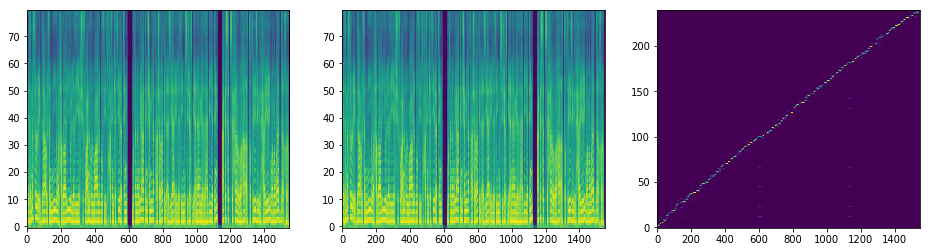

In [13]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [14]:
import time
with torch.no_grad():
    start = time.time()
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
    end = time.time()
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)
print (f'infer time {end - start}')

infer time 2.136042833328247


#### (Optional) Remove WaveGlow bias

In [71]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 